<br> </br>
<font size = 8> <center> AI Strategy and Digital transformation </center> </font>
<font size = 6> <center>  <b> 5. Tree based models </b> </center>
<br>
<font size = 5> <center> Piotr Wójcik </center> </font>
<font size = 5> <center> University of Warsaw, Poland
<font size = 5> <center> pwojcik@wne.uw.edu.pl
<br> </br>
<font size = 5> <center>  January 2025 </center> </font>
</center> </font>

In [60]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/szkolenia/2025-01_Bucharest'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/szkolenia/2025-01_Bucharest


In [61]:
# lets import all the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import xgboost as xgb
import lightgbm as lgb

In [62]:
# lets load the imputed churn data stored before
with open('outputs/churn_prepared.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    churn_train_encoded = pickle.load(f)
    churn_test_encoded = pickle.load(f)

churn_test_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_open
2089,122823,-1.179263,0.490392,4.0,0.0,-1.875667,-0.460621,-0.047547,-0.341229,-0.402278,...,0.178986,0,0,0,1,0,0,0,0,0
8911,674482,0.824459,-0.276069,2.0,5.0,1.382108,-0.146121,-0.363695,-1.324011,-1.306320,...,-0.365464,0,0,1,0,0,0,0,0,1
8411,529000,0.824459,0.490392,4.0,2.0,0.880912,-0.094396,0.268601,0.641554,0.501764,...,-0.347316,1,0,0,1,0,0,0,0,1
7311,344732,-0.427867,0.490392,4.0,5.0,-0.372079,-0.429807,-0.363695,0.641554,-1.306320,...,1.826854,0,0,0,1,0,0,0,0,1
9211,957784,0.699226,-1.042530,2.0,2.0,1.131510,0.098896,-0.995992,2.607119,-1.306320,...,-0.223907,1,0,0,1,0,0,0,0,1


# Decision tree

In [63]:
# Split the data into features (X) and target (y)
# IMPORTANT! remember that customer ID is not a sensible predictor!

churn_train_X = churn_train_encoded.drop(['account_status_closed', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_closed']

# Create a decision tree model
# selected optional parameters:
# - max_depth: maximum depth of the tree (default = None)
# - min_samples_split:  minimum number of samples required to split a node (default = 2)
# - min_samples_leaf: minimum number of samples required to be at a leaf node (default = 1)
# - ccp_alpha: Complexity parameter used for pruning the tree (default = 0, no pruning)

churn_dt = DecisionTreeClassifier(criterion = "gini", # default, "entropy" can be used alternatively
                                  ccp_alpha = 0.003, # complexity parameter
                                  max_depth = 5,
                                  min_samples_leaf = 0.001, # float means a share of the total sample (2%)
                                  random_state = 123)

# Fit on the entire training data (no cross-validation here)
churn_dt.fit(churn_train_X, churn_train_y)

DecisionTreeClassifier(ccp_alpha=0.003, max_depth=5, min_samples_leaf=0.001,
                       random_state=123)

In [64]:
# we can print a textual summary of the tree
#  which shows each split, feature used, threshold, etc.
tree_rules = export_text(churn_dt,
                         feature_names = list(churn_train_X.columns))

print(tree_rules)

|--- total_transaction_count <= -0.45
|   |--- credit_card_debt_balance <= -0.62
|   |   |--- period_inactive <= -0.83
|   |   |   |--- class: 0
|   |   |--- period_inactive >  -0.83
|   |   |   |--- transaction_count_ratio <= -0.27
|   |   |   |   |--- class: 1
|   |   |   |--- transaction_count_ratio >  -0.27
|   |   |   |   |--- class: 1
|   |--- credit_card_debt_balance >  -0.62
|   |   |--- total_products <= -0.52
|   |   |   |--- class: 1
|   |   |--- total_products >  -0.52
|   |   |   |--- total_transaction_amount <= -0.43
|   |   |   |   |--- class: 0
|   |   |   |--- total_transaction_amount >  -0.43
|   |   |   |   |--- transaction_count_ratio <= -0.40
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- transaction_count_ratio >  -0.40
|   |   |   |   |   |--- class: 0
|--- total_transaction_count >  -0.45
|   |--- credit_card_debt_balance <= -0.70
|   |   |--- total_transaction_amount <= -0.01
|   |   |   |--- class: 0
|   |   |--- total_transaction_amount >  -0.01
|   |

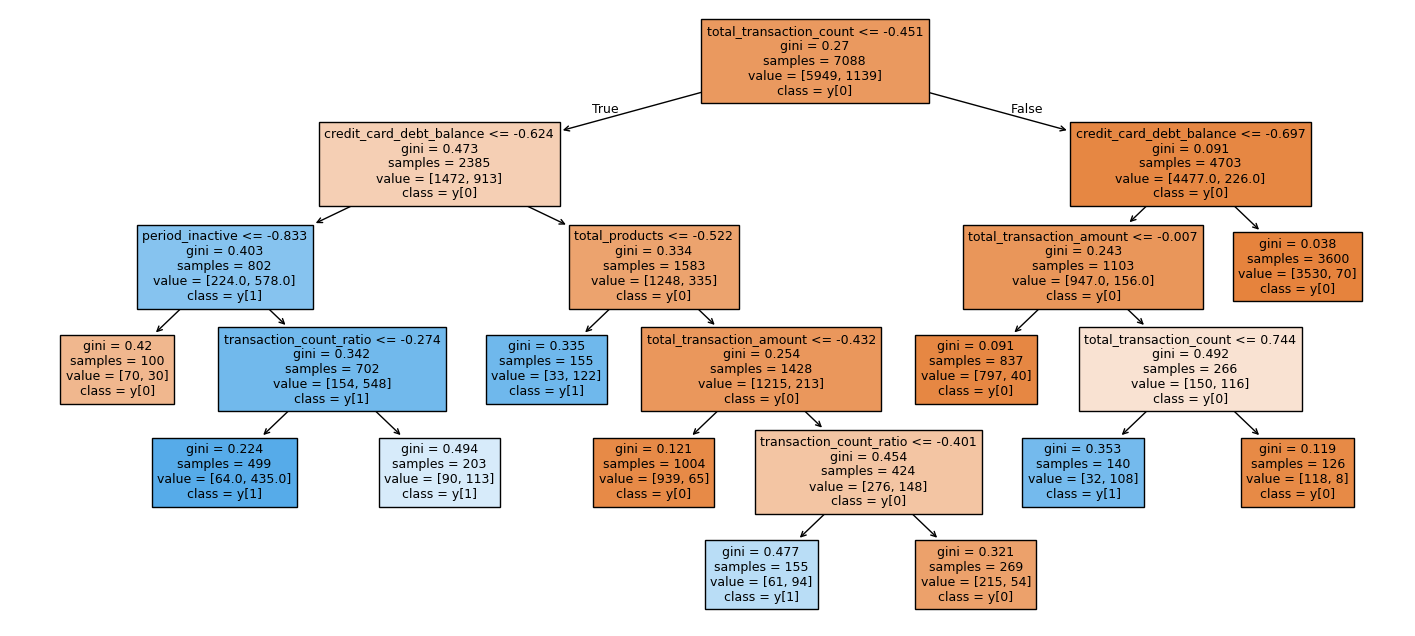

In [65]:
# or plot the resulting tree

plt.figure(figsize=(18, 8))
plot_tree(churn_dt,
          feature_names = churn_train_X.columns,
          class_names = True,
          filled = True,
          fontsize = 9)             # increase font size)
plt.show()

# In each node one can see:
# - the predicted outcome (here: y[0]/y[1]
# - distribution of the target variable (intensity of colors also reflects probability of 0 or 1)
# - size of the node
# - gini (or entropy) of a particular node
# - the splitting rule (not in the leaves)

In [66]:
# check its expected performance on a new dataset with the use of cross-validation

# cross-validation
cv5 = KFold(n_splits = 5,
            shuffle = True,
            random_state = 123)

# Perform cross-validation and compute AUC scores
cv_scores = cross_val_score(
    estimator = churn_dt,
    X = churn_train_X,
    y = churn_train_y,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)

# Report the results
print("AUC scores from each fold:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

# not bad

AUC scores from each fold: [0.92819064 0.93287297 0.89607483 0.88980858 0.90214075]
Mean AUC: 0.9098175543784046


In [67]:
# lets try to find an optimal decision tree for our data

# define custom tuning grid
dt_grid = {'max_depth' : [None, 2, 4, 6, 8, 10, 12],
           'criterion': ['gini', 'entropy'],
           'ccp_alpha' : [0, 0.01, 0.005, 0.003, 0.001],
           'min_samples_leaf': [0.01, 0.02, 0.05]}

# Set up of GridSearchCV
churn_dt_tuned = GridSearchCV(
    estimator = churn_dt, # defined above
    param_grid = dt_grid,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)  # Use all available CPU cores (optional)

# Fit on training data
churn_dt_tuned.fit(churn_train_X, churn_train_y)

# Print or inspect the best parameters and scores
print("Best parameters:", churn_dt_tuned.best_params_)
print("Best AUC:", churn_dt_tuned.best_score_)

# it improved a lot!

Best parameters: {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 0.01}
Best AUC: 0.9512928008216427


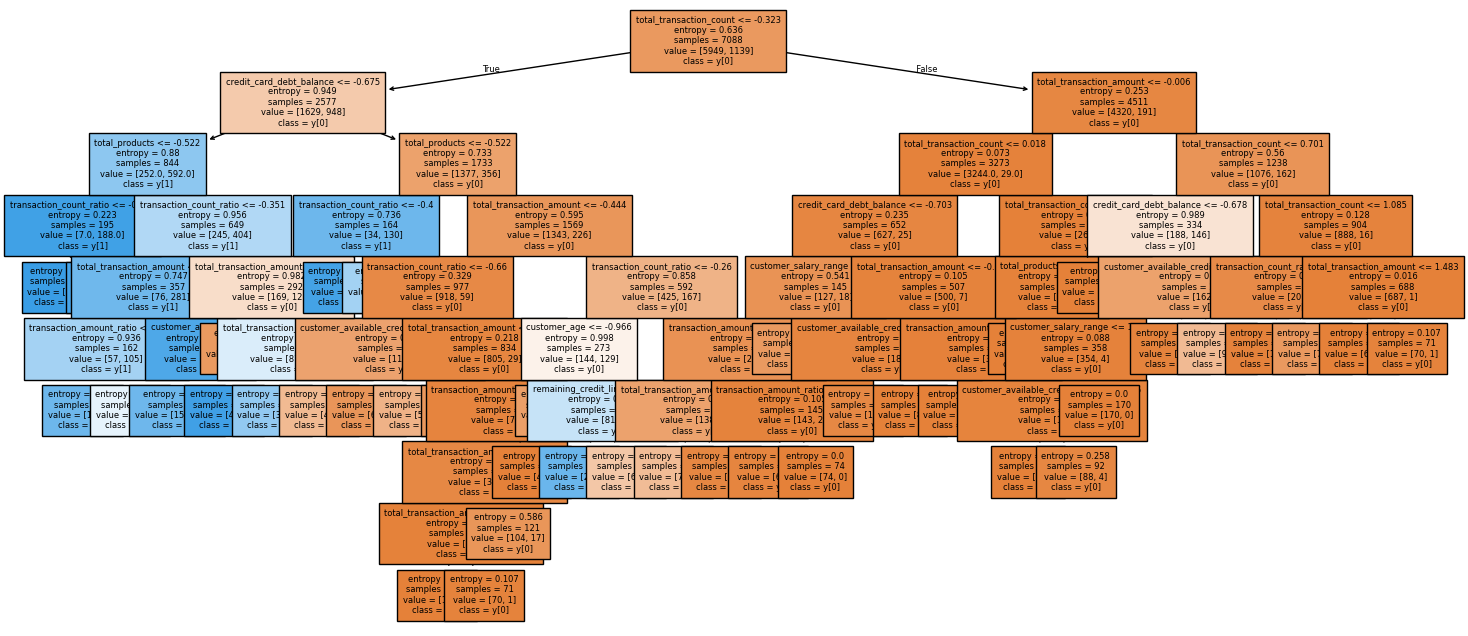

In [68]:
# lets plot the optimized tree

# Extract the best estimator
model_churn_dt_best = churn_dt_tuned.best_estimator_

plt.figure(figsize = (18, 8))
plot_tree(model_churn_dt_best,
          feature_names = churn_train_X.columns,
          class_names = True,
          filled = True,
          fontsize = 6)
plt.show()

# much larger than the one we started with

In [69]:
# lets store the best tree model for further analyses
with open("outputs/model_churn_dt_best.pkl", 'wb') as file:
    pickle.dump(model_churn_dt_best, file)

# Random forest

In [70]:
# what is the square root of the number of predictors?

math.sqrt(churn_train_X.shape[1])

# lets use it in the first model

4.898979485566356

In [71]:
# and create a random forest model
# the most important parameters:
# - n_estimators: number of trees in the forest (default = 100)
# - max_features: number of features to consider when looking for the best split
#                 {"sqrt", "log2", None}, int or float, default = "sqrt"
# selected optional parameters related to a single tree - same as before:
# - criterion:  function to measure the quality of a split (default = "gini")
# - max_depth: maximum depth of the tree (default = None)
# - min_samples_split:  minimum number of samples required to split a node (default = 2)
# - min_samples_leaf: minimum number of samples required to be at a leaf node (default = 1)
# - ccp_alpha: Complexity parameter used for pruning the tree (default = 0, no pruning)

# lets try to use default values of all arguments - they make sense
churn_rf = RandomForestClassifier(random_state = 123,
                                  max_features = "sqrt")

# Fit on the entire training data (no cross-validation here)
churn_rf.fit(churn_train_X, churn_train_y)

RandomForestClassifier(random_state=123)

In [72]:
# check its expected performance on a new dataset with the use of cross-validation

# Perform cross-validation and compute AUC scores
cv_scores = cross_val_score(
    estimator = churn_rf,
    X = churn_train_X,
    y = churn_train_y,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)

# Report the results
print("AUC scores from each fold:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

# better than a single tree

AUC scores from each fold: [0.98839278 0.98118834 0.98187703 0.981044   0.98169115]
Mean AUC: 0.9828386609114675


In [73]:
# Let's see if we can further improve it, which can be hard...

# Define the Random Forest parameter grid
# focusing on the parameters of the forest and
# using default parameters of the tree, if they work so well

rf_grid = {'n_estimators': [200, 300], # we omit the default value 100
           'max_features': [10, 15]} # we omit the default value 'sqrt' close to 5

# Set up GridSearchCV
churn_rf_tuned = GridSearchCV(estimator = churn_rf,
                              param_grid = rf_grid,
                              scoring = 'roc_auc',
                              cv = cv5,
                              n_jobs = -1,  # Use all CPU cores
                              verbose = 1)   # Show progress

# Fit the model on the training data
churn_rf_tuned.fit(churn_train_X, churn_train_y)

# Print the best parameters and best score
print("Best parameters:", churn_rf_tuned.best_params_)
print("Best AUC:", churn_rf_tuned.best_score_)

# looks like we can still slightly improve performance compared to the default settings

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'max_features': 10, 'n_estimators': 300}
Best AUC: 0.9837409156876322


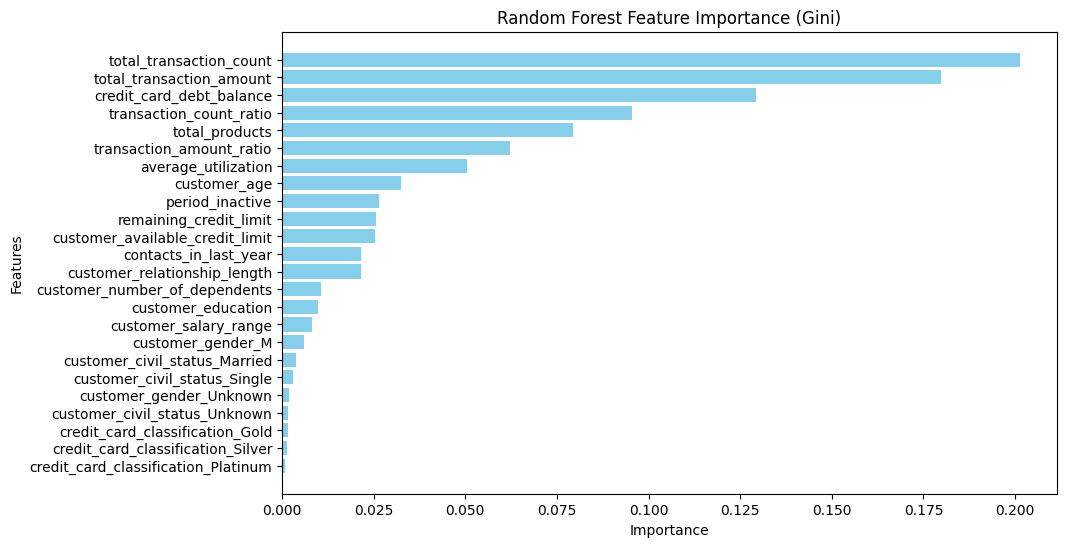

In [75]:
# based on the metric used ('gini' or 'entropy') one can assess the importance of predictors

# Extract the best model
model_churn_rf_best = churn_rf_tuned.best_estimator_

# Get feature importances
importances = model_churn_rf_best.feature_importances_
feature_names = churn_train_X.columns

# Create a DataFrame for importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

# Plot the importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance (Gini)')
plt.gca().invert_yaxis()
plt.show()


In [76]:
# lets store the best random forest model for further analyses
with open("outputs/model_churn_rf_best.pkl", 'wb') as file:
    pickle.dump(model_churn_rf_best, file)

# AdaBoost

In [77]:
# lets check how the AdaBoost performs within cross-validation
# on the same folds

# The most important arguments:
# - estimator - by default the decision tree with max_depth=1 (so decision stump)
# - n_estimators - by default 50
# - learning_rate - weight applied to each classifier at each boosting iteration (default = 1)
#                  A higher learning rate increases the contribution of each classifier.

# IMPORTANT! There is a trade-off between the learning_rate and n_estimators parameters!

# Initialize AdaBoost Classifier with default values
churn_adaboost = AdaBoostClassifier(random_state = 123)

ada_grid = {'n_estimators': [50, 100, 200], # we omit the default value 100
           'learning_rate': [0.2, 0.5, 1, 2]} # we omit the default value 'sqrt' close to 5

# Set up GridSearchCV
churn_adaboost_tuned = GridSearchCV(estimator = churn_adaboost,
                                    param_grid = ada_grid,
                                    scoring = 'roc_auc',
                                    cv = cv5,
                                    n_jobs = -1,  # Use all CPU cores
                                    verbose=1   # Show progress
                                    )

# Fit the model using GridSearchCV
churn_adaboost_tuned.fit(churn_train_X, churn_train_y)

# Print the best parameters and best score
print("Best parameters:", churn_adaboost_tuned.best_params_)
print("Best AUC:", churn_adaboost_tuned.best_score_)

# VERY GOOD score for such a simple model

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 1, 'n_estimators': 200}
Best AUC: 0.9780398804445


In [78]:
# lets store the best adaboost model for further analyses

# Extract the best model
model_churn_ada_best = churn_adaboost_tuned.best_estimator_

# and save it
with open("outputs/model_churn_ada_best.pkl", 'wb') as file:
    pickle.dump(model_churn_ada_best, file)

# LightGBM - tuning of hyperparameters

Hyperperameters to control in order to improve your model efficiency:

1. `num_leaves`: This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to $2^{max\_depth}$. Value more than this will result in overfitting.
2. `min_data_in_leaf`: Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
3. `max_depth`: We also can use max_depth to limit the tree depth explicitly.

For Faster Speed:

* Use bagging by setting `bagging_fraction` and `bagging_freq`.
* Use feature sub-sampling by setting `feature_fraction`.
* Use small `max_bin`.
* Use `save_binary` to speed up data loading in future learning.

For better accuracy:

* Use large `max_bin` (may be slower).
* Use small `learning_rate` with large `num_iterations`
* Use large `num_leaves` (may cause over-fitting)
* Use bigger training data
* Try dart
* Try to use categorical feature directly.

To deal with over-fitting:

* Use small `max_bin`
* Use small `num_leaves`
* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
* Use `bagging` by set `bagging_fraction` and `bagging_freq`
* Use feature sub-sampling by set `feature_fraction`
* Use bigger training data
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to regularization
* Try `max_depth` to avoid growing deep tree

For more information check:

* https://github.com/Microsoft/LightGBM
* https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst



In [79]:
# https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python

# LightGBM

# lets start with the default values of the parameters

churn_lgbm = lgb.LGBMClassifier(random_state = 123)

# Fit on the entire training data (no cross-validation here)
churn_lgbm.fit(churn_train_X, churn_train_y)

[LightGBM] [Info] Number of positive: 1139, number of negative: 5949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160694 -> initscore=-1.653072
[LightGBM] [Info] Start training from score -1.653072


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(random_state=123)

In [80]:
# check its expected performance on a new dataset with the use of cross-validation

# Perform cross-validation and compute AUC scores
cv_scores = cross_val_score(
    estimator = churn_lgbm,
    X = churn_train_X,
    y = churn_train_y,
    scoring = 'roc_auc',
    cv = cv5,
    n_jobs = -1)

# Report the results
print("AUC scores from each fold:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

# best out of all so far

AUC scores from each fold: [0.99305613 0.98631811 0.99058484 0.9894504  0.9877549 ]
Mean AUC: 0.9894328754155735


In [81]:
# can this be still optimized?!!

# Lets try!

# First we need to define the parameter grid for LightGBM
lgbm_grid = {
    'n_estimators': [50, 100, 200],        # Number of boosting iterations (default = 100)
    'learning_rate': [0.05, 0.1, 0.2],     # Learning rate (default = 0.1)
    'max_depth': [3, 5, 7],                # Maximum tree depth (default = -1)
    'num_leaves': [15, 31, 63],            # Number of leaves in each tree (default = 31)
    }

# Set up GridSearchCV
churn_lgbm_tuned = GridSearchCV(estimator = churn_lgbm,
                                param_grid = lgbm_grid,
                                scoring = 'roc_auc',
                                cv = cv5,          # 5-fold cross-validation
                                n_jobs = -1,       # Use all CPU cores
                                verbose = 1        # Show progress
                                )

# Fit the model using GridSearchCV
churn_lgbm_tuned.fit(churn_train_X, churn_train_y)

# Print the best parameters and best score
print("Best parameters:", churn_lgbm_tuned.best_params_)
print("Best AUC:", churn_lgbm_tuned.best_score_)

# Looks like it can!

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 1139, number of negative: 5949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160694 -> initscore=-1.653072
[LightGBM] [Info] Start training from score -1.653072
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 15}
Best AUC: 0.989932344402542


In [83]:
# lets store the best lightgbm model for further analyses

# Extract the best model
model_churn_lgbm_best = churn_lgbm_tuned.best_estimator_

# and save it
with open("outputs/model_churn_lgbm_best.pkl", 'wb') as file:
    pickle.dump(model_churn_lgbm_best, file)

# Exercises 5.

## Exercise 5.1

Estimate two more tree based algorithms - apply the default hyperparameters first and then try to make some tuning

* xgboost classifier:
  * https://xgboost.readthedocs.io/en/stable/python/index.html
* Gradient Boosting Classifier
  * https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
  * https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm



# XGboost

there are TWO TYPES of parameters - related to the SIZE of the tree and with BOOSTING algorithm

Boosting hyperparameters:
1. **n_estimators** - number of boosting rounds
2. **learning_rate ** - learning rate (eta) - for higher values, model training is faster - range: [0, 1] In turn, low values give better results, provided that the algorithm is trained on a sufficiently large number of trees. This, however, (considerably) increases its computational and time complexity

Selected tree related hyperparameters:
3. **Max_depth** - maximum depth of the tree - range [1, infinity]
4. **gamma** - Minimum Loss Reduction, minimal reduction of the optimized function required to perform the next split in the current final tree node. A high value means a more conservative model. range: [0, infinity]. One can try with different values of this parameter however usually other parameters are responsible for model optimization
5. **colsample_bytree** - the percentage of predictors used in the search for optimal divisions (just like in random forests). High values can lead to overfitting of the model. Low values can lead to lower model accuracy. It is recommended to manipulate this parameter. range: (0, 1)
6. **min_child_weight** - interpretation similar to the minimum number observations at the leaf - range: [0, infinity]
7. **subsample** - the size of the subsample randomly drawn from the training set used to train the model. 1 means 100% (whole training set) typical values: [0.5, 1]

In [ ]:
# Place for solution to Exercise 5.1

## Exercise 5.2

Compare the performance of ALL the above applied tree based models on the test sample using AUROC and Balanced accuracy.



In [ ]:
# Place for solution to Exercise 5.2


## Exercise 5.3

Apply 5 selected tree based algorithms on the `houses` dataset.
How they compare with the results of a simple logistic regression or KNN?

In [ ]:
# Place for solution to Exercise 5.3